# Carolo Mattia 232126

# Environment Configuration

initializing all work variables and libraries


In [12]:
import os

DEVICE = 'cuda:0'
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
!pip install transformers

In [50]:
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
import torch
import os
import json
from pprint import pprint
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Data Preparation

## Download Datasets

Clone the repo containing ATIS and SNIPS and set their paths to be used later.

In [51]:
!git clone https://github.com/BrownFortress/IntentSlotDatasets.git

DATASET_PATHS = {"ATIS": "./IntentSlotDatasets/ATIS/", 
                 "SNIPS": "./IntentSlotDatasets/SNIPS/"}

fatal: destination path 'IntentSlotDatasets' already exists and is not an empty directory.


## Load Data

Load the datasets into a dictionary `dataset[<dataset_name>][<split>]` is a list of instances that represent the different samples where each instance is composed by an utterance, an intent, and a slot.

In [16]:
import os
import json
from pprint import pprint

dataset = dict()

for name, path in DATASET_PATHS.items():
    dataset[name] = dict()
    for split in ["train", "test", "valid"]:
        split_path = os.path.join(path, split + ".json")
        if os.path.exists(split_path):
            with open(split_path) as fp:
                dataset[name][split] = json.load(fp)
                print(name, split, len(dataset[name][split]))

train_raw_SNIPS = dataset['SNIPS']['valid']
pprint(train_raw_SNIPS[0])

ATIS train 4978
ATIS test 893
SNIPS train 13084
SNIPS test 700
SNIPS valid 700
{'intent': 'AddToPlaylist',
 'slots': 'O O O O O O B-music_item O B-playlist_owner B-playlist I-playlist O',
 'utterance': 'i d like to have this track onto my classical relaxations '
              'playlist'}


### Create validation set for the ATIS part

Since the dataset is missing the validation test we will create it by taking instances from the training set using the method applied during lab lectures

In [45]:
tmp_train_raw_ATIS = dataset['ATIS']['train']
test_raw_ATIS = dataset['ATIS']['test']
# First we get the 10% of dataset, then we compute the percentage of these examples 
# on the training set which is around 11% 
portion = round(((len(tmp_train_raw_ATIS) + len(test_raw_ATIS)) * 0.10)/(len(tmp_train_raw_ATIS)),2)


intents_ATIS = [x['intent'] for x in tmp_train_raw_ATIS] # We stratify on intents
count_y_ATIS = Counter(intents_ATIS)

Y_ATIS = []
X_ATIS = []
mini_Train_ATIS = []

for id_y, y in enumerate(intents_ATIS):
    # IT MAKES NO SENSE TO PUT IN DEV SET INTENTS THAT ONLY APPEAR ONCE
    if count_y_ATIS[y] > 1: # Some intents have only one instance, we put them in training
        X_ATIS.append(tmp_train_raw_ATIS[id_y])
        Y_ATIS.append(y)
    else:
        mini_Train_ATIS.append(tmp_train_raw_ATIS[id_y])
# Random Stratify
X_train_ATIS, X_dev_ATIS, y_train_ATIS, y_dev_ATIS = train_test_split(X_ATIS, Y_ATIS, test_size=portion, 
                                                    random_state=42, 
                                                    shuffle=True,
                                                    stratify=Y_ATIS)
X_train_ATIS.extend(mini_Train_ATIS)
train_raw_ATIS = X_train_ATIS
dev_raw_ATIS = X_dev_ATIS

y_test_ATIS = [x['intent'] for x in test_raw_ATIS]

# Intent distribution
print('Train:')
pprint({k:round(v/len(y_train_ATIS),3)*100 for k, v in sorted(Counter(y_train_ATIS).items())})
print('Dev:'), 
pprint({k:round(v/len(y_dev_ATIS),3)*100 for k, v in sorted(Counter(y_dev_ATIS).items())})
print('Test:') 
pprint({k:round(v/len(y_test_ATIS),3)*100 for k, v in sorted(Counter(y_test_ATIS).items())})
print('='*89)
# Dataset size
print('TRAIN size:', len(train_raw_ATIS))
print('DEV size:', len(dev_raw_ATIS))
print('TEST size:', len(test_raw_ATIS))

#print(dev_raw_ATIS[0])
#print(train_raw_ATIS[0])

Train:
{'abbreviation': 2.9000000000000004,
 'aircraft': 1.6,
 'airfare': 8.5,
 'airline': 3.2,
 'airline+flight_no': 0.0,
 'airport': 0.4,
 'capacity': 0.3,
 'city': 0.4,
 'distance': 0.4,
 'flight': 73.7,
 'flight+airfare': 0.4,
 'flight_no': 0.3,
 'flight_time': 1.0999999999999999,
 'ground_fare': 0.4,
 'ground_service': 5.1,
 'meal': 0.1,
 'quantity': 1.0,
 'restriction': 0.1}
Dev:
{'abbreviation': 3.0,
 'aircraft': 1.7000000000000002,
 'airfare': 8.5,
 'airline': 3.2,
 'airport': 0.3,
 'capacity': 0.3,
 'city': 0.3,
 'distance': 0.3,
 'flight': 73.7,
 'flight+airfare': 0.5,
 'flight_no': 0.2,
 'flight_time': 1.0,
 'ground_fare': 0.3,
 'ground_service': 5.2,
 'meal': 0.2,
 'quantity': 1.0,
 'restriction': 0.2}
Test:
{'abbreviation': 3.6999999999999997,
 'aircraft': 1.0,
 'airfare': 5.4,
 'airfare+flight': 0.1,
 'airline': 4.3,
 'airport': 2.0,
 'capacity': 2.4,
 'city': 0.7000000000000001,
 'day_name': 0.2,
 'distance': 1.0999999999999999,
 'flight': 70.8,
 'flight+airfare': 1.3,
 

Cells used to fast output some meaningful tasks

- 23/07 Dropped old usages if IntentAndSlots and Lang therefore coulda be useless

In [42]:
wordsATIS = sum([x['utterance'].split() for x in train_raw_ATIS], []) # No set() since we want to compute 
                                                            # the cutoff
corpusATIS = train_raw_ATIS + dev_raw_ATIS + test_raw_ATIS # We do not wat unk labels, 
                                        # however this depends on the research purpose
slotsATIS = set(sum([line['slots'].split() for line in corpusATIS],[]))
intentsATIS = set([line['intent'] for line in corpusATIS])

print(len(intentsATIS))

26


In [19]:
train_raw_SNIPS = dataset['SNIPS']['train']
test_raw_SNIPS = dataset['SNIPS']['test']
dev_raw_SNIPS = dataset['SNIPS']['valid']
print('Train samples:', len(train_raw_SNIPS))
print('Test samples:', len(test_raw_SNIPS))
print('valid samples:', len(dev_raw_SNIPS))

pprint(test_raw_SNIPS[0])

Train samples: 13084
Test samples: 700
valid samples: 700
{'intent': 'AddToPlaylist',
 'slots': 'O B-artist I-artist O O B-playlist I-playlist O',
 'utterance': 'add sabrina salerno to the grime instrumentals playlist'}


In [43]:
wordsSNIPS= sum([x['utterance'].split() for x in train_raw_ATIS], []) # No set() since we want to compute 
                                                            # the cutoff
corpusSNIPS = train_raw_SNIPS + dev_raw_SNIPS + test_raw_SNIPS # We do not wat unk labels, 
                                        # however this depends on the research purpose
slotsSNIPS = set(sum([line['slots'].split() for line in corpusSNIPS],[]))
intentsSNIPS = set([line['intent'] for line in corpusSNIPS])

print(len(intentsSNIPS))

7


## conll

In [21]:
from __future__ import division, print_function, unicode_literals

import sys
from collections import defaultdict

def split_tag(chunk_tag):
    """
    split chunk tag into IOBES prefix and chunk_type
    e.g. 
    B-PER -> (B, PER)
    O -> (O, None)
    """
    if chunk_tag == 'O':
        return ('O', None)
    return chunk_tag.split('-', maxsplit=1)

def is_chunk_end(prev_tag, tag):
    """
    check if the previous chunk ended between the previous and current word
    e.g. 
    (B-PER, I-PER) -> False
    (B-LOC, O)  -> True

    Note: in case of contradicting tags, e.g. (B-PER, I-LOC)
    this is considered as (B-PER, B-LOC)
    """
    prefix1, chunk_type1 = split_tag(prev_tag)
    prefix2, chunk_type2 = split_tag(tag)

    if prefix1 == 'O':
        return False
    if prefix2 == 'O':
        return prefix1 != 'O'

    if chunk_type1 != chunk_type2:
        return True

    return prefix2 in ['B', 'S'] or prefix1 in ['E', 'S']

def is_chunk_start(prev_tag, tag):
    """
    check if a new chunk started between the previous and current word
    """
    prefix1, chunk_type1 = split_tag(prev_tag)
    prefix2, chunk_type2 = split_tag(tag)

    if prefix2 == 'O':
        return False
    if prefix1 == 'O':
        return prefix2 != 'O'

    if chunk_type1 != chunk_type2:
        return True

    return prefix2 in ['B', 'S'] or prefix1 in ['E', 'S']


def calc_metrics(tp, p, t, percent=True):
    """
    compute overall precision, recall and FB1 (default values are 0.0)
    if percent is True, return 100 * original decimal value
    """
    precision = tp / p if p else 0
    recall = tp / t if t else 0
    fb1 = 2 * precision * recall / (precision + recall) if precision + recall else 0
    if percent:
        return 100 * precision, 100 * recall, 100 * fb1
    else:
        return precision, recall, fb1


def count_chunks(true_seqs, pred_seqs):
    """
    true_seqs: a list of true tags
    pred_seqs: a list of predicted tags

    return: 
    correct_chunks: a dict (counter), 
                    key = chunk types, 
                    value = number of correctly identified chunks per type
    true_chunks:    a dict, number of true chunks per type
    pred_chunks:    a dict, number of identified chunks per type

    correct_counts, true_counts, pred_counts: similar to above, but for tags
    """
    correct_chunks = defaultdict(int)
    true_chunks = defaultdict(int)
    pred_chunks = defaultdict(int)

    correct_counts = defaultdict(int)
    true_counts = defaultdict(int)
    pred_counts = defaultdict(int)

    prev_true_tag, prev_pred_tag = 'O', 'O'
    correct_chunk = None

    for true_tag, pred_tag in zip(true_seqs, pred_seqs):
        if true_tag == pred_tag:
            correct_counts[true_tag] += 1
        true_counts[true_tag] += 1
        pred_counts[pred_tag] += 1

        _, true_type = split_tag(true_tag)
        _, pred_type = split_tag(pred_tag)

        if correct_chunk is not None:
            true_end = is_chunk_end(prev_true_tag, true_tag)
            pred_end = is_chunk_end(prev_pred_tag, pred_tag)

            if pred_end and true_end:
                correct_chunks[correct_chunk] += 1
                correct_chunk = None
            elif pred_end != true_end or true_type != pred_type:
                correct_chunk = None

        true_start = is_chunk_start(prev_true_tag, true_tag)
        pred_start = is_chunk_start(prev_pred_tag, pred_tag)

        if true_start and pred_start and true_type == pred_type:
            correct_chunk = true_type
        if true_start:
            true_chunks[true_type] += 1
        if pred_start:
            pred_chunks[pred_type] += 1

        prev_true_tag, prev_pred_tag = true_tag, pred_tag
    if correct_chunk is not None:
        correct_chunks[correct_chunk] += 1

    return (correct_chunks, true_chunks, pred_chunks, 
        correct_counts, true_counts, pred_counts)

def get_result(correct_chunks, true_chunks, pred_chunks,
    correct_counts, true_counts, pred_counts, verbose=True):
    """
    if verbose, print overall performance, as well as preformance per chunk type;
    otherwise, simply return overall prec, rec, f1 scores
    """
    # sum counts
    sum_correct_chunks = sum(correct_chunks.values())
    sum_true_chunks = sum(true_chunks.values())
    sum_pred_chunks = sum(pred_chunks.values())

    sum_correct_counts = sum(correct_counts.values())
    sum_true_counts = sum(true_counts.values())

    nonO_correct_counts = sum(v for k, v in correct_counts.items() if k != 'O')
    nonO_true_counts = sum(v for k, v in true_counts.items() if k != 'O')

    chunk_types = sorted(list(set(list(true_chunks) + list(pred_chunks))))

    # compute overall precision, recall and FB1 (default values are 0.0)
    prec, rec, f1 = calc_metrics(sum_correct_chunks, sum_pred_chunks, sum_true_chunks)
    res = (prec, rec, f1)
    if not verbose:
        return res

    # print overall performance, and performance per chunk type
    
    print("processed %i tokens with %i phrases; " % (sum_true_counts, sum_true_chunks), end='')
    print("found: %i phrases; correct: %i.\n" % (sum_pred_chunks, sum_correct_chunks), end='')
    try:
        print("accuracy: %6.2f%%; (non-O)" % (100*nonO_correct_counts/nonO_true_counts))
        print("accuracy: %6.2f%%; " % (100*sum_correct_counts/sum_true_counts), end='')
        print("precision: %6.2f%%; recall: %6.2f%%; FB1: %6.2f" % (prec, rec, f1))
    except ZeroDivisionError:
        print("conll doesn't work")

    # for each chunk type, compute precision, recall and FB1 (default values are 0.0)
    for t in chunk_types:
        prec, rec, f1 = calc_metrics(correct_chunks[t], pred_chunks[t], true_chunks[t])
        print("%17s: " %t , end='')
        print("precision: %6.2f%%; recall: %6.2f%%; FB1: %6.2f" %
                    (prec, rec, f1), end='')
        print("  %d" % pred_chunks[t])

    return res
    # you can generate LaTeX output for tables like in
    # http://cnts.uia.ac.be/conll2003/ner/example.tex
    # but I'm not implementing this

def evaluate(true_seqs, pred_seqs, verbose=True):
    (correct_chunks, true_chunks, pred_chunks,
        correct_counts, true_counts, pred_counts) = count_chunks(true_seqs, pred_seqs)
    result = get_result(correct_chunks, true_chunks, pred_chunks,
        correct_counts, true_counts, pred_counts, verbose=verbose)
    return result

## Lang and Dataset Classes

The `Lang` class stores information about the vocabulary and output labels. Each word/intent/slot label is mapped to an integer. These integers are then fed into the embedding layers of the neural models.

`Dataset` is for dividing the whole dataset into smaller batches.

In [ ]:
import torch
import torch.utils.data as data

class Lang:#Alphabet like structure from Process.py in stackPropagation taken from scratch from some examples
    PAD_TOKEN = '[PAD]'
    UNK_TOKEN = '[UNK]'

    def __init__(self):
        self._vocab = []
        self._word_ids = dict()
        self._intents = []
        self._intent_ids = dict()
        self._slots = []
        self._slot_ids = dict()

    def build_vocab(self, data):
        vocab = set()
        for x in data:
            vocab = vocab.union(set(x['utterance'].split()))
        self._vocab = [Lang.PAD_TOKEN] + list(vocab) + [Lang.UNK_TOKEN]
        self._word_ids = dict((w, i) for i, w in enumerate(self._vocab))

    def build_intents(self, data):
        self._intents = list(set(x['intent'] for x in data))
        self._intent_ids = dict((w, i) for i, w in enumerate(self._intents))

    def build_slots(self, data):
        slots = set()
        for x in data:
            slots = slots.union(set(x['slots'].split()))
        self._slots = list(slots)
        self._slot_ids = dict((w, i) for i, w in enumerate(self._slots))
    
    def get_word_id(self, word):
        if word in self._word_ids:
            return self._word_ids[word]
        else:
            return self._word_ids[Lang.UNK_TOKEN]
    
    def get_intent_id(self, intent):
        return self._intent_ids[intent]
    
    def get_slot_id(self, intent):
        return self._slot_ids[intent]
    
    def get_slot_label(self, i):
        return self._slots[i]

    def get_intent_label(self, i):
        return self._intents[i]
    
    def get_word(self, i):
        return self._vocab[i]
    
    @property
    def vocab_size(self):
        return len(self._vocab)
    
    @property
    def num_intents(self):
        return len(self._intents)
    
    @property
    def num_slots(self):
        return len(self._slots)
    
    @property
    def vocab(self):
        return self._vocab

# taken mainly from lab lectures
class Dataset(data.Dataset):

    def __init__(self, data, lang):
        self._x = []
        self._y_intent = []
        self._y_slot = []
        i =0
        for sample in data:
            i += 1
            #print(i)
            utter_ids = list(map(lang.get_word_id, sample['utterance'].split()))
            slot_ids = list(map(lang.get_slot_id, sample['slots'].split()))
            self._x.append(utter_ids)
            self._y_slot.append(slot_ids)
            self._y_intent.append(lang.get_intent_id(sample['intent']))
    
    def __len__(self):
        return len(self._x)

    def __getitem__(self, i):
        x = torch.Tensor(self._x[i])
        y_intent = self._y_intent[i]
        y_slot = torch.Tensor(self._y_slot[i])
        return {'utterance': x, 'intent': y_intent, 'slots': y_slot}

def collate_fn(data):
    def merge(sequences):
        lengths = [len(seq) for seq in sequences]
        max_len = 1 if max(lengths)==0 else max(lengths)
        padded_seqs = torch.LongTensor(len(sequences),max_len).fill_(0)
        for i, seq in enumerate(sequences):
            end = lengths[i]
            padded_seqs[i, :end] = seq
        padded_seqs = padded_seqs.detach()
        return padded_seqs, lengths

    data.sort(key=lambda x: len(x['utterance']), reverse=True) 
    new_item = {}
    for key in data[0].keys():
        new_item[key] = [d[key] for d in data]
    src_utt, _ = merge(new_item['utterance'])
    y_slots, y_lengths = merge(new_item["slots"])
    intent = torch.LongTensor(new_item["intent"])
    
    src_utt = src_utt.to(DEVICE)
    y_slots = y_slots.to(DEVICE)
    intent = intent.to(DEVICE)
    y_lengths = torch.LongTensor(y_lengths).to(DEVICE)
    
    new_item["utterances"] = src_utt
    new_item["intents"] = intent
    new_item["y_slots"] = y_slots
    new_item["slots_len"] = y_lengths
    return new_item


- old implementation of lang used for stack propagation introduced during Lab

In [23]:
PAD_TOKEN = '[PAD]'
UNK_TOKEN = '[UNK]'

from collections import Counter
class Langa():
    def __init__(self, words, intents, slots, cutoff=0):
        self.word2id = self.w2id(words, cutoff=cutoff, unk=True)
        self.slot2id = self.lab2id(slots)
        self.intent2id = self.lab2id(intents, pad=False)
        self.id2word = {v:k for k, v in self.word2id.items()}
        self.id2slot = {v:k for k, v in self.slot2id.items()}
        self.id2intent = {v:k for k, v in self.intent2id.items()}
        
    def w2id(self, elements, cutoff=None, unk=True):
        vocab = {'pad': PAD_TOKEN}
        if unk:
            vocab['unk'] = len(vocab)
        count = Counter(elements)
        for k, v in count.items():
            if v > cutoff:
                vocab[k] = len(vocab)
        return vocab
    
    def lab2id(self, elements, pad=True):
        vocab = {}
        if pad:
            vocab['pad'] = PAD_TOKEN
        for elem in elements:
                vocab[elem] = len(vocab)
        return vocab

In [24]:
#lang_ATIS = Lang(wordsATIS,intentsATIS,slotsATIS,cutoff = 0)
#lang_SNIPS = Lang(wordsSNIPS,intentsSNIPS,slotsSNIPS,cutoff = 0)

# Bi-model RNN

Wang, Yu, Yilin Shen, and Hongxia Jin. "A bi-model based rnn semantic frame parsing model for intent detection and slot filling." arXiv preprint [arXiv:1812.10235](https://arxiv.org/abs/1812.10235) (2018).

Original code: https://github.com/ray075hl/Bi-Model-Intent-And-Slot

In [27]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class BiModelRNN(nn.Module):

    def __init__(self, embed_dim, hidden_dim, num_intents, num_slots, vocab_size):
        super(BiModelRNN, self).__init__()
        self._embed = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self._intent_enc = nn.LSTM(embed_dim, hidden_dim, 2, bidirectional=True)
        self._slot_enc = nn.LSTM(embed_dim, hidden_dim, 2, bidirectional=True)
        self._y_intent1 = nn.Linear(2 * hidden_dim, 2 * hidden_dim)
        self._y_intent2 = nn.Linear(2 * hidden_dim, num_intents)
        self._y_slot1 = nn.Linear(2 * hidden_dim, 2 * hidden_dim)
        self._y_slot2 = nn.Linear(2 * hidden_dim, num_slots)

    def forward(self, input, seq_lens):
        x = self._embed(input).permute(1, 0, 2)
        x = pack_padded_sequence(x, seq_lens.cpu().numpy())
        with torch.no_grad():
            _, (h1, s1) = self._intent_enc(x)
            _, (h2, s2) = self._slot_enc(x)
        y_intent, _ = self._intent_enc(x, (h2, s1))
        y_slot, _ = self._slot_enc(x, (h1, s2))
        y_intent = self._y_intent1(pad_packed_sequence(y_intent)[0])
        y_slot = self._y_slot1(pad_packed_sequence(y_slot)[0])
        self._h_intent, self._s_intent = h1.detach(), s1.detach()
        self._h_slot, self._s_slot = h2.detach(), s2.detach()
        return self._y_intent2(y_intent[-1,:,:]), self._y_slot2(y_slot).permute(1, 2, 0)

# Attention Bi-RNN

Liu, Bing, and Ian Lane. "Attention-based recurrent neural network models for joint intent detection and slot filling." arXiv preprint [arXiv:1609.01454](https://arxiv.org/pdf/1609.01454.pdf) (2016).

In [28]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class AttentionBiRNN(nn.Module):

    def __init__(self, embed_dim, hidden_dim, num_intents, num_slots, vocab_size):
        super(AttentionBiRNN, self).__init__()
        self._embed = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self._blstm = nn.LSTM(embed_dim, hidden_dim, 2, bidirectional=True)
        self._attention = nn.MultiheadAttention(2 * hidden_dim, 4)
        self._y_intent = nn.Linear(2 * hidden_dim, num_intents)
        self._y_slot = nn.Linear(2 * hidden_dim, num_slots)

    def forward(self, x, seq_lens):
        x = self._embed(x).permute(1, 0, 2)
        x = pack_padded_sequence(x, seq_lens.cpu().numpy())
        x, _ = self._blstm(x)
        x, _ = pad_packed_sequence(x)
        x, _ = self._attention(x, x, x)
        return self._y_intent(x[-1,:,:]), self._y_slot(x).permute(1, 2, 0)

# BERT

Chen, Qian, Zhu Zhuo, and Wen Wang. "Bert for joint intent classification and slot filling." arXiv preprint [arXiv:1902.10909](https://arxiv.org/abs/1902.10909) (2019).

In [29]:
import torch.nn as nn
from transformers import BertModel, BertConfig, BertTokenizer

class BERT(nn.Module):

    def __init__(self, num_intents, num_slots, lang):
        super(BERT, self).__init__()
        self._lang = lang
        self._tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', never_split=lang.vocab)
        self._tokenizer.add_tokens(lang.vocab)
        self._bert = BertModel.from_pretrained('bert-base-uncased')
        self._bert.to(DEVICE)
        self._bert.resize_token_embeddings(len(self._tokenizer))
        self._intent = nn.Linear(self._bert.config.hidden_size, num_intents)
        self._slots = nn.Linear(self._bert.config.hidden_size, num_slots)
    
    def _to_text(self, input):
        texts = []
        for sample in input:
            texts.append(' '.join(lang.get_word(i) for i in sample if i > 0))
        return texts
    
    def forward(self, input, seq_lens):
        with torch.no_grad():
            encoding = self._tokenizer(self._to_text(input),
                                        add_special_tokens=True,   
                                        truncation=True,
                                        padding=True,
                                        return_tensors="pt").to(DEVICE)
            bert_output = self._bert(**encoding)
        x_intent = bert_output.pooler_output
        x_slots = bert_output.last_hidden_state[:,:input.size()[1],:]
        return self._intent(x_intent), self._slots(x_slots).permute(0, 2, 1)

# Loops and helpers

Here the main loop train and loop eval can be found. Those are called during the training and evaluation part 

In [64]:
from sklearn.metrics import classification_report

def train_loop(train_loader, optimizer, slot_loss_fn, intent_loss_fn, model):
    model.train()
    # Training loop
    loss_array = []
    for sample in train_loader:
        optimizer.zero_grad()
        intent, slots = model(sample['utterances'], sample['slots_len'])
        intent_loss = intent_loss_fn(intent, sample['intents'])
        slot_loss = slot_loss_fn(slots, sample['y_slots'])
        # Add + 0.001 * sum(p.pow(2.0).sum() for p in model.parameters()) to loss for L2 regularization
        loss = intent_loss + slot_loss + 0.001 * sum(p.pow(2.0).sum() for p in model.parameters())
        loss_array.append(loss.item())
        loss.backward()
        optimizer.step()
    return loss_array

def eval_loop(checker, model, lang,slot_loss_fn,intent_loss_fn):
    #model.eval()
    loss_array = []
    
    ref_intents = []
    hyp_intents = []
    
    ref_slots = []
    hyp_slots = []
    #softmax = nn.Softmax(dim=1) # Use Softmax if you need the actual probability
    with torch.no_grad():
        for sample in checker:
            # Loss calc
            intent, slots = model(sample['utterances'], sample['slots_len'])
            intent_loss = intent_loss_fn(intent, sample['intents'])
            slot_loss = slot_loss_fn(slots, sample['y_slots'])
            # Add + 0.001 * sum(p.pow(2.0).sum() for p in model.parameters()) to loss for L2 regularization
            loss = intent_loss + slot_loss + 0.001 * sum(p.pow(2.0).sum() for p in model.parameters())
            loss_array.append(loss.item())
            out_intents = [lang.get_intent_label(x)
                        for x in torch.argmax(intent, dim=1).tolist()]
            gt_intents = [lang.get_intent_label(x) for x in sample['intents'].tolist()]  
            ref_intents.extend(gt_intents)
            hyp_intents.extend(out_intents) 

            #
            output_slots = torch.argmax(slots, dim=1)
            for id_seq, seq in enumerate(output_slots):
                length = sample['slots_len'].tolist()[id_seq]
                #utt_ids = sample['utterance'][id_seq][:length].tolist()
                gt_ids = sample['y_slots'][id_seq].tolist()
                gt_slots = [lang.get_slot_label(elem) for elem in gt_ids[:length]]
                #utterance = [lang.get_word(int(elem)) for elem in utt_ids]
                to_decode = seq[:length].tolist()
                ref_slots.append(gt_slots)
                tmp_seq = []
                for _, elem in enumerate(to_decode):
                    tmp_seq.append(lang.get_slot_label(elem))
                hyp_slots.append(tmp_seq)
    test_loss.append(np.mean(loss_array))
    f1s = []
    for ref, hyp in zip(ref_slots, hyp_slots):
        #print(len(hyp))
        #print(len(ref))
        _, _, f1 = evaluate(ref, hyp, verbose=False)
        f1s.append(f1)
    slots_f1.append(np.mean(f1s) / 100)

    report_intent = classification_report(ref_intents, hyp_intents, 
                                            zero_division=False, output_dict=True)

    #results = evaluate(ref_slots, hyp_slots) #usually crashes don't cut

    return ref_slots,hyp_slots,test_loss, slots_f1, report_intent



# Using the SNIPS Dataset

- Modify `NUM_EPOCHS` to change the number of epochs for each run -> converges usually in 50 epochs
- Uncomment the line containing `#for run in tqdm(range(NUM_EPOCHS)):` and the last three of the cell to get multiple runs. The results are saved in the last three lines so uncomment even just the desired value

In [57]:
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from tqdm import tqdm

NUM_EPOCHS = 100
NUM_RUNS = 5

lang = Lang()
lang.build_vocab(train_raw_SNIPS + test_raw_SNIPS)
lang.build_intents(train_raw_SNIPS + test_raw_SNIPS)
lang.build_slots(train_raw_SNIPS + test_raw_SNIPS)

print("Vocab size =", lang.vocab_size)
print("No. intents =", lang.num_intents)
print("No. slots =", lang.num_slots)

train_dataset = Dataset(train_raw_SNIPS, lang)
test_dataset = Dataset(test_raw_SNIPS, lang)
valid_dataset = Dataset(dev_raw_SNIPS,lang)

train_loader = DataLoader(train_dataset, batch_size=128, collate_fn=collate_fn, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=64, collate_fn=collate_fn)

# -------- Un-comment the model you'd like to run and comment the rest -----
#model = BiModelRNN(200, 50, lang.num_intents, lang.num_slots, lang.vocab_size)
#model = BERT(lang.num_intents, lang.num_slots, lang)
model = AttentionBiRNN(200, 50, lang.num_intents, lang.num_slots, lang.vocab_size)
# --------------------------------------------------------------------------

model.train()
model.to(DEVICE)

# -------- Can experiment with other optimizers (e.g. SGD or rmsprop) ------
optimizer = optim.Adam(model.parameters())
# --------------------------------------------------------------------------

intent_loss_fn = nn.CrossEntropyLoss(ignore_index=0)
slot_loss_fn = nn.CrossEntropyLoss()

train_loss = []
test_loss = []
intent_acc = []
slots_f1 = []
ref_slots = []
hyp_slots = []
rep_intents = []
#for run in tqdm(range(NUM_RUNS)):
for epoch in tqdm(range(NUM_EPOCHS)):
    total_loss_values = []

    loss_array = train_loop(train_loader,optimizer,slot_loss_fn,intent_loss_fn,model)

    #print(loss_array)
    train_loss.append(np.mean(total_loss_values))

    ref_slots, hyp_slots, test_loss, slots_f1, report_intent = eval_loop(test_loader,model,lang,slot_loss_fn, intent_loss_fn)
    
    intent_acc.append(report_intent['accuracy'])

    print("Training loss =", train_loss[-1])
    print("Training perplexity =", np.exp(train_loss[-1]))
    print("Validation loss =", test_loss[-1])
    print("Validation perplexity =", np.exp(test_loss[-1]))
    print("Slot filling F1 =", slots_f1[-1])
    print("Intent detection acc. =", intent_acc[-1])

ref_slot, hyp_slot, _, _, report_intent = eval_loop(valid_loader,model,lang, slot_loss_fn, intent_loss_fn)
#ref_slots.append(ref_slot)
#hyp_slots.append(hyp_slot)
#rep_intents.append(report_intent)

Vocab size = 11791
No. intents = 7
No. slots = 72
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


  0%|          | 0/100 [00:00<?, ?it/s]/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
  1%|          | 1/100 [00:02<04:42,  2.85s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2363.795498934659
Validation perplexity = inf
Slot filling F1 = 0.0
Intent detection acc. = 0.8


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
  2%|▏         | 2/100 [00:05<04:37,  2.83s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2363.2363059303975
Validation perplexity = inf
Slot filling F1 = 0.05107709750566893
Intent detection acc. = 0.8242857142857143


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
  3%|▎         | 3/100 [00:08<04:31,  2.80s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2363.101717862216
Validation perplexity = inf
Slot filling F1 = 0.12574036281179135
Intent detection acc. = 0.8314285714285714


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
  4%|▍         | 4/100 [00:11<04:29,  2.81s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2363.101895419034
Validation perplexity = inf
Slot filling F1 = 0.15882787054215627
Intent detection acc. = 0.8328571428571429


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
  5%|▌         | 5/100 [00:14<04:28,  2.83s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2363.198486328125
Validation perplexity = inf
Slot filling F1 = 0.22752304838019122
Intent detection acc. = 0.8328571428571429


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
  6%|▌         | 6/100 [00:16<04:24,  2.82s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2363.4483531605115
Validation perplexity = inf
Slot filling F1 = 0.26268198468198467
Intent detection acc. = 0.8314285714285714


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
  7%|▋         | 7/100 [00:19<04:21,  2.81s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2363.7637162642045
Validation perplexity = inf
Slot filling F1 = 0.3445843283700426
Intent detection acc. = 0.8342857142857143


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
  8%|▊         | 8/100 [00:22<04:18,  2.81s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2364.0913307883525
Validation perplexity = inf
Slot filling F1 = 0.4266563436563437
Intent detection acc. = 0.8342857142857143


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
  9%|▉         | 9/100 [00:25<04:14,  2.80s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2364.5161576704545
Validation perplexity = inf
Slot filling F1 = 0.5438334522620236
Intent detection acc. = 0.8328571428571429


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 10%|█         | 10/100 [00:28<04:10,  2.79s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2365.072199041193
Validation perplexity = inf
Slot filling F1 = 0.5017146028574601
Intent detection acc. = 0.8328571428571429


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 11%|█         | 11/100 [00:30<04:07,  2.78s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2365.6580921519885
Validation perplexity = inf
Slot filling F1 = 0.5964181453467168
Intent detection acc. = 0.83


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 12%|█▏        | 12/100 [00:33<04:04,  2.78s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2366.273193359375
Validation perplexity = inf
Slot filling F1 = 0.622673691387977
Intent detection acc. = 0.8285714285714286


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 13%|█▎        | 13/100 [00:36<04:01,  2.78s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2366.941339666193
Validation perplexity = inf
Slot filling F1 = 0.6351054659626088
Intent detection acc. = 0.8357142857142857


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 14%|█▍        | 14/100 [00:39<03:58,  2.77s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2367.4879039417615
Validation perplexity = inf
Slot filling F1 = 0.6678769960198533
Intent detection acc. = 0.8328571428571429


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 15%|█▌        | 15/100 [00:41<03:54,  2.76s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2368.0217063210225
Validation perplexity = inf
Slot filling F1 = 0.6710947861662148
Intent detection acc. = 0.83


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 16%|█▌        | 16/100 [00:44<03:51,  2.75s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2368.478604403409
Validation perplexity = inf
Slot filling F1 = 0.6836326411683555
Intent detection acc. = 0.83


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 17%|█▋        | 17/100 [00:47<03:48,  2.76s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2369.0685813210225
Validation perplexity = inf
Slot filling F1 = 0.6778105981320267
Intent detection acc. = 0.8285714285714286


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 18%|█▊        | 18/100 [00:50<03:46,  2.76s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2369.5793235085225
Validation perplexity = inf
Slot filling F1 = 0.6892371279514137
Intent detection acc. = 0.8257142857142857


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 19%|█▉        | 19/100 [00:52<03:43,  2.76s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2369.9626908735795
Validation perplexity = inf
Slot filling F1 = 0.6951392536035393
Intent detection acc. = 0.83


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 20%|██        | 20/100 [00:55<03:41,  2.77s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2370.276123046875
Validation perplexity = inf
Slot filling F1 = 0.7091264608407465
Intent detection acc. = 0.8314285714285714


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 21%|██        | 21/100 [00:58<03:39,  2.77s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2370.560236150568
Validation perplexity = inf
Slot filling F1 = 0.705371620443049
Intent detection acc. = 0.8271428571428572


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 22%|██▏       | 22/100 [01:01<03:35,  2.77s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2370.8028675426135
Validation perplexity = inf
Slot filling F1 = 0.7142287945481222
Intent detection acc. = 0.8285714285714286


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 23%|██▎       | 23/100 [01:03<03:32,  2.76s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2371.0654740767045
Validation perplexity = inf
Slot filling F1 = 0.7097961720818864
Intent detection acc. = 0.8257142857142857


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 24%|██▍       | 24/100 [01:06<03:29,  2.76s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2371.295587713068
Validation perplexity = inf
Slot filling F1 = 0.7130592185592185
Intent detection acc. = 0.83


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 25%|██▌       | 25/100 [01:09<03:27,  2.77s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2371.50439453125
Validation perplexity = inf
Slot filling F1 = 0.7228981177552605
Intent detection acc. = 0.8257142857142857


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 26%|██▌       | 26/100 [01:12<03:24,  2.77s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2371.739990234375
Validation perplexity = inf
Slot filling F1 = 0.6989307042164183
Intent detection acc. = 0.8271428571428572


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 27%|██▋       | 27/100 [01:15<03:21,  2.77s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2371.9557661576705
Validation perplexity = inf
Slot filling F1 = 0.7096094104308389
Intent detection acc. = 0.8242857142857143


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 28%|██▊       | 28/100 [01:17<03:18,  2.76s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2372.2031693892045
Validation perplexity = inf
Slot filling F1 = 0.7069677619299468
Intent detection acc. = 0.8271428571428572


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 29%|██▉       | 29/100 [01:20<03:16,  2.77s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2372.4045188210225
Validation perplexity = inf
Slot filling F1 = 0.707490390561819
Intent detection acc. = 0.83


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 30%|███       | 30/100 [01:23<03:14,  2.78s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2372.547429865057
Validation perplexity = inf
Slot filling F1 = 0.7103850712779284
Intent detection acc. = 0.8285714285714286


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 31%|███       | 31/100 [01:26<03:11,  2.78s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2372.826726740057
Validation perplexity = inf
Slot filling F1 = 0.710897705469134
Intent detection acc. = 0.8242857142857143


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 32%|███▏      | 32/100 [01:28<03:09,  2.79s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2373.1901633522725
Validation perplexity = inf
Slot filling F1 = 0.7125565307708165
Intent detection acc. = 0.83


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 33%|███▎      | 33/100 [01:31<03:07,  2.80s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2373.9850630326705
Validation perplexity = inf
Slot filling F1 = 0.6920264497407355
Intent detection acc. = 0.8285714285714286


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 34%|███▍      | 34/100 [01:34<03:04,  2.79s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2374.3337846235795
Validation perplexity = inf
Slot filling F1 = 0.7246059971774257
Intent detection acc. = 0.8342857142857143


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 35%|███▌      | 35/100 [01:37<03:01,  2.79s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2374.5183327414775
Validation perplexity = inf
Slot filling F1 = 0.7395274566703136
Intent detection acc. = 0.8357142857142857


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 36%|███▌      | 36/100 [01:40<02:58,  2.79s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2374.64404296875
Validation perplexity = inf
Slot filling F1 = 0.7304683530754958
Intent detection acc. = 0.8357142857142857


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 37%|███▋      | 37/100 [01:42<02:55,  2.79s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2374.724276455966
Validation perplexity = inf
Slot filling F1 = 0.7396733147804575
Intent detection acc. = 0.8342857142857143


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 38%|███▊      | 38/100 [01:45<02:53,  2.79s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2374.7984730113635
Validation perplexity = inf
Slot filling F1 = 0.738174345495774
Intent detection acc. = 0.8342857142857143


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 39%|███▉      | 39/100 [01:48<02:50,  2.79s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2374.854070490057
Validation perplexity = inf
Slot filling F1 = 0.7406060566417709
Intent detection acc. = 0.8342857142857143


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 40%|████      | 40/100 [01:51<02:47,  2.78s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2374.913174715909
Validation perplexity = inf
Slot filling F1 = 0.7399381055452484
Intent detection acc. = 0.8342857142857143


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 41%|████      | 41/100 [01:54<02:44,  2.78s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2374.968084161932
Validation perplexity = inf
Slot filling F1 = 0.7336355350998207
Intent detection acc. = 0.8342857142857143


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 42%|████▏     | 42/100 [01:56<02:41,  2.78s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2375.0037064985795
Validation perplexity = inf
Slot filling F1 = 0.7407902375402375
Intent detection acc. = 0.8328571428571429


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 43%|████▎     | 43/100 [01:59<02:38,  2.78s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2375.056884765625
Validation perplexity = inf
Slot filling F1 = 0.7328390022675738
Intent detection acc. = 0.8342857142857143


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 44%|████▍     | 44/100 [02:02<02:35,  2.79s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2375.1412242542615
Validation perplexity = inf
Slot filling F1 = 0.7358630575773434
Intent detection acc. = 0.8342857142857143


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 45%|████▌     | 45/100 [02:05<02:33,  2.79s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2375.2231223366475
Validation perplexity = inf
Slot filling F1 = 0.7348648177219606
Intent detection acc. = 0.8342857142857143


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 46%|████▌     | 46/100 [02:08<02:30,  2.78s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2375.2903275923295
Validation perplexity = inf
Slot filling F1 = 0.732757314114457
Intent detection acc. = 0.8342857142857143


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 47%|████▋     | 47/100 [02:10<02:27,  2.79s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2375.340753728693
Validation perplexity = inf
Slot filling F1 = 0.7355224854510568
Intent detection acc. = 0.8328571428571429


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 48%|████▊     | 48/100 [02:13<02:24,  2.79s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2375.478426846591
Validation perplexity = inf
Slot filling F1 = 0.7265663741020885
Intent detection acc. = 0.8342857142857143


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 49%|████▉     | 49/100 [02:16<02:22,  2.79s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2375.6496803977275
Validation perplexity = inf
Slot filling F1 = 0.7150965066679352
Intent detection acc. = 0.8314285714285714


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 50%|█████     | 50/100 [02:19<02:19,  2.79s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2375.819247159091
Validation perplexity = inf
Slot filling F1 = 0.7317170726099298
Intent detection acc. = 0.8342857142857143


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 51%|█████     | 51/100 [02:21<02:16,  2.79s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2376.0687144886365
Validation perplexity = inf
Slot filling F1 = 0.7401005740291454
Intent detection acc. = 0.8314285714285714


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 52%|█████▏    | 52/100 [02:24<02:13,  2.79s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2376.319269353693
Validation perplexity = inf
Slot filling F1 = 0.7340734345020059
Intent detection acc. = 0.8285714285714286


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 53%|█████▎    | 53/100 [02:27<02:10,  2.78s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2376.542879971591
Validation perplexity = inf
Slot filling F1 = 0.7279133881991023
Intent detection acc. = 0.8285714285714286


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 54%|█████▍    | 54/100 [02:30<02:08,  2.78s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2376.700439453125
Validation perplexity = inf
Slot filling F1 = 0.7411196422624994
Intent detection acc. = 0.83


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 55%|█████▌    | 55/100 [02:33<02:05,  2.78s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2376.919034090909
Validation perplexity = inf
Slot filling F1 = 0.7243540744969317
Intent detection acc. = 0.8314285714285714


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 56%|█████▌    | 56/100 [02:35<02:02,  2.78s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2377.040771484375
Validation perplexity = inf
Slot filling F1 = 0.7394777920492206
Intent detection acc. = 0.8328571428571429


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 57%|█████▋    | 57/100 [02:38<01:59,  2.79s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2377.2007279829545
Validation perplexity = inf
Slot filling F1 = 0.7423967778253493
Intent detection acc. = 0.8342857142857143


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 58%|█████▊    | 58/100 [02:41<01:57,  2.79s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2377.2771218039775
Validation perplexity = inf
Slot filling F1 = 0.746203169846027
Intent detection acc. = 0.8328571428571429


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 59%|█████▉    | 59/100 [02:44<01:54,  2.79s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2377.370205965909
Validation perplexity = inf
Slot filling F1 = 0.7413115297401011
Intent detection acc. = 0.83


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 60%|██████    | 60/100 [02:46<01:51,  2.78s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2377.4925648082385
Validation perplexity = inf
Slot filling F1 = 0.7511053232481804
Intent detection acc. = 0.8328571428571429


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 61%|██████    | 61/100 [02:49<01:48,  2.78s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2377.6552290482955
Validation perplexity = inf
Slot filling F1 = 0.7492462854605713
Intent detection acc. = 0.8314285714285714


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 62%|██████▏   | 62/100 [02:52<01:45,  2.78s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2377.913995916193
Validation perplexity = inf
Slot filling F1 = 0.7517032570603999
Intent detection acc. = 0.8328571428571429


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 63%|██████▎   | 63/100 [02:55<01:42,  2.78s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2378.172518643466
Validation perplexity = inf
Slot filling F1 = 0.7464203732775161
Intent detection acc. = 0.8342857142857143


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 64%|██████▍   | 64/100 [02:58<01:40,  2.78s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2378.418035333807
Validation perplexity = inf
Slot filling F1 = 0.7487617224045795
Intent detection acc. = 0.8328571428571429


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 65%|██████▌   | 65/100 [03:00<01:37,  2.79s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2378.550115411932
Validation perplexity = inf
Slot filling F1 = 0.7540057561486132
Intent detection acc. = 0.8342857142857143


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 66%|██████▌   | 66/100 [03:03<01:34,  2.79s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2378.741876775568
Validation perplexity = inf
Slot filling F1 = 0.7475135737278594
Intent detection acc. = 0.8357142857142857


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 67%|██████▋   | 67/100 [03:06<01:32,  2.79s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2378.877352627841
Validation perplexity = inf
Slot filling F1 = 0.7535637695637696
Intent detection acc. = 0.8342857142857143


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 68%|██████▊   | 68/100 [03:09<01:29,  2.79s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2379.018954190341
Validation perplexity = inf
Slot filling F1 = 0.7595356310356312
Intent detection acc. = 0.8314285714285714


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 69%|██████▉   | 69/100 [03:12<01:26,  2.78s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2379.1760031960225
Validation perplexity = inf
Slot filling F1 = 0.7510457161885733
Intent detection acc. = 0.8342857142857143


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 70%|███████   | 70/100 [03:14<01:23,  2.78s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2379.2347523082385
Validation perplexity = inf
Slot filling F1 = 0.7615913293056151
Intent detection acc. = 0.8342857142857143


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 71%|███████   | 71/100 [03:17<01:20,  2.78s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2379.3005593039775
Validation perplexity = inf
Slot filling F1 = 0.7524170749885034
Intent detection acc. = 0.8342857142857143


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 72%|███████▏  | 72/100 [03:20<01:17,  2.78s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2379.3310990767045
Validation perplexity = inf
Slot filling F1 = 0.7667060558489129
Intent detection acc. = 0.8314285714285714


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 73%|███████▎  | 73/100 [03:23<01:15,  2.78s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2379.419522372159
Validation perplexity = inf
Slot filling F1 = 0.757216735645307
Intent detection acc. = 0.8314285714285714


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 74%|███████▍  | 74/100 [03:25<01:12,  2.78s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2379.5160910866475
Validation perplexity = inf
Slot filling F1 = 0.7637999222999222
Intent detection acc. = 0.8328571428571429


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 75%|███████▌  | 75/100 [03:28<01:09,  2.78s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2379.685946377841
Validation perplexity = inf
Slot filling F1 = 0.7590999238856382
Intent detection acc. = 0.83


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 76%|███████▌  | 76/100 [03:31<01:06,  2.78s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2379.890536221591
Validation perplexity = inf
Slot filling F1 = 0.7358410478410478
Intent detection acc. = 0.8314285714285714


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 77%|███████▋  | 77/100 [03:34<01:04,  2.78s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2380.508123224432
Validation perplexity = inf
Slot filling F1 = 0.7534968999254713
Intent detection acc. = 0.8257142857142857


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 78%|███████▊  | 78/100 [03:37<01:01,  2.79s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2381.073974609375
Validation perplexity = inf
Slot filling F1 = 0.7566305995591711
Intent detection acc. = 0.8257142857142857


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 79%|███████▉  | 79/100 [03:39<00:58,  2.78s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2381.3039328835225
Validation perplexity = inf
Slot filling F1 = 0.7686713048855905
Intent detection acc. = 0.8271428571428572


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 80%|████████  | 80/100 [03:42<00:55,  2.79s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2381.399169921875
Validation perplexity = inf
Slot filling F1 = 0.7694226804941091
Intent detection acc. = 0.8285714285714286


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 81%|████████  | 81/100 [03:45<00:52,  2.78s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2381.4633567116475
Validation perplexity = inf
Slot filling F1 = 0.776297829154972
Intent detection acc. = 0.8285714285714286


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 82%|████████▏ | 82/100 [03:48<00:50,  2.79s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2381.5014870383525
Validation perplexity = inf
Slot filling F1 = 0.7792535083963655
Intent detection acc. = 0.8285714285714286


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 83%|████████▎ | 83/100 [03:51<00:47,  2.79s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2381.5300736860795
Validation perplexity = inf
Slot filling F1 = 0.7747496233924805
Intent detection acc. = 0.8285714285714286


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 84%|████████▍ | 84/100 [03:53<00:44,  2.79s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2381.5567515980115
Validation perplexity = inf
Slot filling F1 = 0.7765444079729794
Intent detection acc. = 0.8285714285714286


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 85%|████████▌ | 85/100 [03:56<00:41,  2.80s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2381.5787242542615
Validation perplexity = inf
Slot filling F1 = 0.7776864405435835
Intent detection acc. = 0.8285714285714286


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 86%|████████▌ | 86/100 [03:59<00:39,  2.79s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2381.5964133522725
Validation perplexity = inf
Slot filling F1 = 0.7815661243518386
Intent detection acc. = 0.8285714285714286


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 87%|████████▋ | 87/100 [04:02<00:36,  2.80s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2381.610684481534
Validation perplexity = inf
Slot filling F1 = 0.7771396460682175
Intent detection acc. = 0.8285714285714286


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 88%|████████▊ | 88/100 [04:05<00:33,  2.80s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2381.6273970170455
Validation perplexity = inf
Slot filling F1 = 0.7791056324627753
Intent detection acc. = 0.8285714285714286


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 89%|████████▉ | 89/100 [04:07<00:30,  2.80s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2381.6369850852275
Validation perplexity = inf
Slot filling F1 = 0.7815426557569413
Intent detection acc. = 0.83


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 90%|█████████ | 90/100 [04:10<00:27,  2.80s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2381.6548295454545
Validation perplexity = inf
Slot filling F1 = 0.7795118373689802
Intent detection acc. = 0.83


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 91%|█████████ | 91/100 [04:13<00:25,  2.79s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2381.671564275568
Validation perplexity = inf
Slot filling F1 = 0.7824857602714745
Intent detection acc. = 0.83


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 92%|█████████▏| 92/100 [04:16<00:22,  2.81s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2381.6868119673295
Validation perplexity = inf
Slot filling F1 = 0.7832363271648985
Intent detection acc. = 0.83


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 93%|█████████▎| 93/100 [04:19<00:19,  2.84s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2381.7018821022725
Validation perplexity = inf
Slot filling F1 = 0.7801787101787102
Intent detection acc. = 0.83


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 94%|█████████▍| 94/100 [04:21<00:17,  2.83s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2381.7216796875
Validation perplexity = inf
Slot filling F1 = 0.7779375227946655
Intent detection acc. = 0.83


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 95%|█████████▌| 95/100 [04:24<00:14,  2.83s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2381.733154296875
Validation perplexity = inf
Slot filling F1 = 0.7792172589315446
Intent detection acc. = 0.83


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 96%|█████████▌| 96/100 [04:27<00:11,  2.82s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2381.752130681818
Validation perplexity = inf
Slot filling F1 = 0.7786971599828744
Intent detection acc. = 0.8285714285714286


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 97%|█████████▋| 97/100 [04:30<00:08,  2.81s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2381.7619185014205
Validation perplexity = inf
Slot filling F1 = 0.7832311735883164
Intent detection acc. = 0.8285714285714286


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 98%|█████████▊| 98/100 [04:33<00:05,  2.81s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2381.7766557173295
Validation perplexity = inf
Slot filling F1 = 0.7786705675277104
Intent detection acc. = 0.83


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
 99%|█████████▉| 99/100 [04:36<00:02,  2.81s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 2381.9156383167615
Validation perplexity = inf
Slot filling F1 = 0.7617051995623424
Intent detection acc. = 0.8285714285714286


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5852/2870307808.py:69: RuntimeWarning: overflow encountered in exp
  print("Validation perplexity =", np.exp(test_loss[-1]))
100%|██████████| 100/100 [04:38<00:00,  2.79s/it]


Training loss = nan
Training perplexity = nan
Validation loss = 2382.3673872514205
Validation perplexity = inf
Slot filling F1 = 0.7667914902557759
Intent detection acc. = 0.83


### conll evaluation

In [58]:
for ref, hyp in zip(ref_slots, hyp_slots):
        evaluate(ref, hyp)

processed 20 tokens with 2 phrases; found: 3 phrases; correct: 1.
accuracy:  60.00%; (non-O)
accuracy:  80.00%; precision:  33.33%; recall:  50.00%; FB1:  40.00
condition_description: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
   geographic_poi: precision:  50.00%; recall: 100.00%; FB1:  66.67  2
        timeRange: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
processed 18 tokens with 4 phrases; found: 4 phrases; correct: 4.
accuracy: 100.00%; (non-O)
accuracy: 100.00%; precision: 100.00%; recall: 100.00%; FB1: 100.00
party_size_number: precision: 100.00%; recall: 100.00%; FB1: 100.00  1
              poi: precision: 100.00%; recall: 100.00%; FB1: 100.00  1
  restaurant_type: precision: 100.00%; recall: 100.00%; FB1: 100.00  1
 spatial_relation: precision: 100.00%; recall: 100.00%; FB1: 100.00  1
processed 16 tokens with 4 phrases; found: 5 phrases; correct: 2.
accuracy:  50.00%; (non-O)
accuracy:  81.25%; precision:  40.00%; recall:  50.00%; FB1:  44.44
             cit

## Plots

### Loss value x Epoch

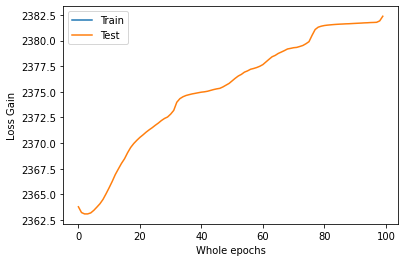

In [59]:
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel('Whole epochs')
plt.ylabel('Loss Gain')
plt.plot(train_loss, label='Train')
plt.plot(test_loss, label='Test')
plt.legend()
plt.show()

### Intent accuracy x Epoch

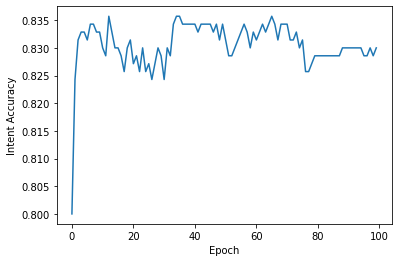

In [60]:
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Intent Accuracy')
plt.plot(intent_acc)
plt.show()

### Slots F1 x Accuracy

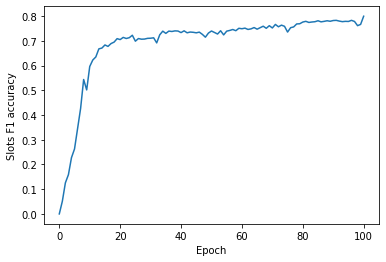

In [61]:
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Slots F1 accuracy')
plt.plot(slots_f1)
plt.show()

# Using the ATIS Dataset

- Modify `NUM_EPOCHS` to change the number of epochs for each run -> converges usually in 50 epochs
- Uncomment the line containing `#for run in tqdm(range(NUM_EPOCHS)):` and the last three of the cell to get multiple runs. The results are saved in the last three lines so uncomment even just the desired value

In [66]:
import numpy as np
from sklearn.metrics import classification_report
import importlib
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader

NUM_EPOCHS = 100
NUM_RUNS = 5

lang = Lang()
lang.build_vocab(train_raw_ATIS + test_raw_ATIS)
lang.build_intents(train_raw_ATIS + test_raw_ATIS)
lang.build_slots(train_raw_ATIS + test_raw_ATIS)

print("Vocab size =", lang.vocab_size)
print("No. intents =", lang.num_intents)
print("No. slots =", lang.num_slots)

train_dataset = Dataset(train_raw_ATIS, lang)
test_dataset = Dataset(test_raw_ATIS, lang)
valid_dataset = Dataset(test_raw_ATIS, lang)

train_loader = DataLoader(train_dataset, batch_size=128, collate_fn=collate_fn, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=64, collate_fn=collate_fn)

# -------- Un-comment the model you'd like to run and comment the rest -----
#model = BiModelRNN(200, 50, lang.num_intents, lang.num_slots, lang.vocab_size)
#model = BERT(lang.num_intents, lang.num_slots, lang)
model = AttentionBiRNN(200, 50, lang.num_intents, lang.num_slots, lang.vocab_size)
# --------------------------------------------------------------------------

model.train()
model.to(DEVICE)

# -------- Can experiment with other optimizers (e.g. SGD or rmsprop) ------
optimizer = optim.Adam(model.parameters())
# --------------------------------------------------------------------------

intent_loss_fn = nn.CrossEntropyLoss(ignore_index=0)
slot_loss_fn = nn.CrossEntropyLoss()

train_loss = []
test_loss = []
intent_acc = []
slots_f1 = []
ref_slots = []
hyp_slots = []
rep_intents = []
#for run in tqdm(range(NUM_RUNS)):
for epoch in tqdm(range(NUM_EPOCHS)):
    total_loss_values = []

    loss_array = train_loop(train_loader,optimizer,slot_loss_fn,intent_loss_fn,model)

    #print(loss_array)
    train_loss.append(np.mean(total_loss_values))

    ref_slots, hyp_slots, test_loss, slots_f1, report_intent = eval_loop(test_loader,model,lang,slot_loss_fn, intent_loss_fn)
    
    intent_acc.append(report_intent['accuracy'])

    print("Training loss =", train_loss[-1])
    print("Training perplexity =", np.exp(train_loss[-1]))
    print("Validation loss =", test_loss[-1])
    print("Validation perplexity =", np.exp(test_loss[-1]))
    print("Slot filling F1 =", slots_f1[-1])
    print("Intent detection acc. =", intent_acc[-1])

ref_slot, hyp_slot, _, _, report_intent = eval_loop(valid_loader,model,lang, slot_loss_fn, intent_loss_fn)
#ref_slots.append(ref_slot)
#hyp_slots.append(hyp_slot)
#rep_intents.append(report_intent)

Vocab size = 919
No. intents = 26
No. slots = 127
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


  0%|          | 0/100 [00:00<?, ?it/s]

Training loss = nan
Training perplexity = nan
Validation loss = 178.22197832380022
Validation perplexity = 2.516643736580244e+77
Slot filling F1 = 0.0
Intent detection acc. = 0.7077267637178052


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 167.983515058245
Validation perplexity = 9.001474188759287e+72
Slot filling F1 = 0.0
Intent detection acc. = 0.7077267637178052


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 158.34781537737166
Validation perplexity = 5.882777732070683e+68
Slot filling F1 = 0.00031994880819068947
Intent detection acc. = 0.7077267637178052


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 149.7509994506836
Validation perplexity = 1.0865074809653496e+65
Slot filling F1 = 0.0
Intent detection acc. = 0.7077267637178052


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 141.60660988943917
Validation perplexity = 3.1547814317242517e+61
Slot filling F1 = 0.0
Intent detection acc. = 0.7054871220604704


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 134.06762913295202
Validation perplexity = 1.678152925209482e+58
Slot filling F1 = 0.0
Intent detection acc. = 0.7390817469204927


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 126.9582154410226
Validation perplexity = 1.3716787111725206e+55
Slot filling F1 = 0.0
Intent detection acc. = 0.7435610302351624


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 120.27146312168666
Validation perplexity = 1.7109320593974774e+52
Slot filling F1 = 0.0
Intent detection acc. = 0.7513997760358343


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 113.88019561767578
Validation perplexity = 2.8677451557672465e+49
Slot filling F1 = 0.006532288167226576
Intent detection acc. = 0.7592385218365062


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 107.79594203404018
Validation perplexity = 6.534055167678296e+46
Slot filling F1 = 0.1998077013194595
Intent detection acc. = 0.7737961926091825


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 102.22172437395368
Validation perplexity = 2.4793099666711516e+44
Slot filling F1 = 0.23637152321362848
Intent detection acc. = 0.8208286674132139


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 96.86449268886021
Validation perplexity = 1.1687312785158356e+42
Slot filling F1 = 0.2597760457782854
Intent detection acc. = 0.8185890257558791


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 91.80755778721401
Validation perplexity = 7.439020302821917e+39
Slot filling F1 = 0.2976702966064668
Intent detection acc. = 0.8331466965285554


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 87.03363909040179
Validation perplexity = 6.283899012084798e+37
Slot filling F1 = 0.30366021312269914
Intent detection acc. = 0.8465845464725644


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 82.45085307529995
Validation perplexity = 6.4261449710043906e+35
Slot filling F1 = 0.3413390702864387
Intent detection acc. = 0.8701007838745801


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 78.17401668003627
Validation perplexity = 8.923681728203647e+33
Slot filling F1 = 0.33552056137160785
Intent detection acc. = 0.8712206047032475


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 74.07665961129325
Validation perplexity = 1.4828065883758045e+32
Slot filling F1 = 0.3489326188818975
Intent detection acc. = 0.8768197088465846


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 70.23482731410435
Validation perplexity = 3.181251027436658e+30
Slot filling F1 = 0.4369467242887619
Intent detection acc. = 0.8779395296752519


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 66.67233984810966
Validation perplexity = 9.024627636700242e+28
Slot filling F1 = 0.42970649920152243
Intent detection acc. = 0.8734602463605823


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 63.197876249040874
Validation perplexity = 2.7956894203197674e+27
Slot filling F1 = 0.449270465913933
Intent detection acc. = 0.8745800671892497


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 59.978842054094585
Validation perplexity = 1.118098680730227e+26
Slot filling F1 = 0.4618873034747795
Intent detection acc. = 0.8701007838745801


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 56.79607745579311
Validation perplexity = 4.6368498495393214e+24
Slot filling F1 = 0.504103488959819
Intent detection acc. = 0.8712206047032475


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 53.96782602582659
Validation perplexity = 2.7411262797999716e+23
Slot filling F1 = 0.5182812227163026
Intent detection acc. = 0.8712206047032475


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 51.07536997113909
Validation perplexity = 1.5196771717132124e+22
Slot filling F1 = 0.5112991490354641
Intent detection acc. = 0.8924972004479284


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 48.51726450238909
Validation perplexity = 1.177010264939522e+21
Slot filling F1 = 0.5182021602070367
Intent detection acc. = 0.883538633818589


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 45.97420147487095
Validation perplexity = 9.254266680980824e+19
Slot filling F1 = 0.5395053412871738
Intent detection acc. = 0.8857782754759238


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 43.641222545078826
Validation perplexity = 8.977225508766028e+18
Slot filling F1 = 0.5266779568571283
Intent detection acc. = 0.8891377379619261


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 41.37012645176479
Validation perplexity = 9.264407162075032e+17
Slot filling F1 = 0.5618197961126622
Intent detection acc. = 0.8947368421052632


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 39.29130118233817
Validation perplexity = 1.1587647898480544e+17
Slot filling F1 = 0.5615891916200798
Intent detection acc. = 0.883538633818589


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 37.33264568873814
Validation perplexity = 1.6344137883667124e+16
Slot filling F1 = 0.5342898139634191
Intent detection acc. = 0.8857782754759238


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 35.33854103088379
Validation perplexity = 2225017177855962.5
Slot filling F1 = 0.5734235193284405
Intent detection acc. = 0.8891377379619261


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 33.567776271275115
Validation perplexity = 378704097722349.6
Slot filling F1 = 0.5950779384369141
Intent detection acc. = 0.8902575587905935


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 31.799499375479563
Validation perplexity = 64617046878854.875
Slot filling F1 = 0.577243619264896
Intent detection acc. = 0.8868980963045913


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 30.21061420440674
Validation perplexity = 13191769184509.281
Slot filling F1 = 0.5868799358409624
Intent detection acc. = 0.8868980963045913


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 28.643535341535294
Validation perplexity = 2752512760597.6914
Slot filling F1 = 0.5777178774939133
Intent detection acc. = 0.8857782754759238


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 27.20848982674735
Validation perplexity = 655385747522.6125
Slot filling F1 = 0.5629510964337393
Intent detection acc. = 0.8913773796192609


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 25.837642669677734
Validation perplexity = 166397055468.93015
Slot filling F1 = 0.6002271863151423
Intent detection acc. = 0.8824188129899216


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 24.563048090253556
Validation perplexity = 46515344774.48701
Slot filling F1 = 0.5890008420421263
Intent detection acc. = 0.8924972004479284


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 23.236188752310618
Validation perplexity = 12340948944.070099
Slot filling F1 = 0.5779471772472892
Intent detection acc. = 0.8846584546472565


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 22.040900775364467
Validation perplexity = 3734578416.371944
Slot filling F1 = 0.6279551597305769
Intent detection acc. = 0.8924972004479284


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 20.890145983014786
Validation perplexity = 1181612635.9010403
Slot filling F1 = 0.6091196300009948
Intent detection acc. = 0.896976483762598


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 19.850864274161204
Validation perplexity = 417946617.9839185
Slot filling F1 = 0.6046819007793252
Intent detection acc. = 0.8924972004479284


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 18.832256725856237
Validation perplexity = 150919437.4913984
Slot filling F1 = 0.6328548086815
Intent detection acc. = 0.8958566629339306


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 17.893548692975724
Validation perplexity = 59029548.171874225
Slot filling F1 = 0.6142970128433938
Intent detection acc. = 0.9003359462486002


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 16.995685713631765
Validation perplexity = 24050965.84612672
Slot filling F1 = 0.6186275520176275
Intent detection acc. = 0.9003359462486002


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 16.23187255859375
Validation perplexity = 11205021.215304725
Slot filling F1 = 0.6321561449631855
Intent detection acc. = 0.8902575587905935


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 15.385990279061454
Validation perplexity = 4808954.597491485
Slot filling F1 = 0.614862605867151
Intent detection acc. = 0.8980963045912654


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 14.579479558127266
Validation perplexity = 2146779.9035610463
Slot filling F1 = 0.5958189250166064
Intent detection acc. = 0.9059350503919373


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 13.739945752280098
Validation perplexity = 927219.6394837811
Slot filling F1 = 0.650506201108785
Intent detection acc. = 0.9059350503919373


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 13.145342894962855
Validation perplexity = 511622.7903824268
Slot filling F1 = 0.6262482840578887
Intent detection acc. = 0.8868980963045913


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 12.440299306597028
Validation perplexity = 252786.18873579561
Slot filling F1 = 0.6431222472935798
Intent detection acc. = 0.9025755879059351


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 11.80377129146031
Validation perplexity = 133755.83519868436
Slot filling F1 = 0.6395674096961891
Intent detection acc. = 0.9059350503919373


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 11.213290010179792
Validation perplexity = 74108.83316460624
Slot filling F1 = 0.654099048891882
Intent detection acc. = 0.9025755879059351


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 10.67966399874006
Validation perplexity = 43462.944294371475
Slot filling F1 = 0.6369024938776255
Intent detection acc. = 0.9092945128779395


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 10.075616564069476
Validation perplexity = 23756.62134473115
Slot filling F1 = 0.6615449702528773
Intent detection acc. = 0.9171332586786114


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 9.66330691746303
Validation perplexity = 15729.715626360965
Slot filling F1 = 0.6584954212936212
Intent detection acc. = 0.9025755879059351


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 9.180231843675886
Validation perplexity = 9703.402184591585
Slot filling F1 = 0.6664927932660625
Intent detection acc. = 0.9036954087346024


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 8.695292336600167
Validation perplexity = 5974.718941418298
Slot filling F1 = 0.6330568084470989
Intent detection acc. = 0.9193729003359462


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 8.311755384717669
Validation perplexity = 4071.4536821078427
Slot filling F1 = 0.6526285984836145
Intent detection acc. = 0.9148936170212766


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 8.118933030537196
Validation perplexity = 3357.4365510339167
Slot filling F1 = 0.6724066812455329
Intent detection acc. = 0.8779395296752519


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 7.602777140481131
Validation perplexity = 2003.7528785038949
Slot filling F1 = 0.6621110001641067
Intent detection acc. = 0.9003359462486002


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 7.081001792635236
Validation perplexity = 1189.1592129367016
Slot filling F1 = 0.6764738739177009
Intent detection acc. = 0.9204927211646137


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 6.74863018308367
Validation perplexity = 852.8896592972022
Slot filling F1 = 0.6555877162309544
Intent detection acc. = 0.9260918253079508


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 6.407346248626709
Validation perplexity = 606.2826209924543
Slot filling F1 = 0.6688578032157761
Intent detection acc. = 0.9249720044792833


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 6.118449449539185
Validation perplexity = 454.15995034973906
Slot filling F1 = 0.6612082044885861
Intent detection acc. = 0.9272116461366181


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 5.85844704083034
Validation perplexity = 350.1799064431815
Slot filling F1 = 0.6936157476513496
Intent detection acc. = 0.9193729003359462


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 5.607885701315744
Validation perplexity = 272.56733958442373
Slot filling F1 = 0.6617043161845875
Intent detection acc. = 0.9126539753639418


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 5.3043786117008755
Validation perplexity = 201.21593033385025
Slot filling F1 = 0.6904193489786976
Intent detection acc. = 0.9204927211646137


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 5.093427658081055
Validation perplexity = 162.94743401355365
Slot filling F1 = 0.7074685901163076
Intent detection acc. = 0.9260918253079508


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 4.851289681025913
Validation perplexity = 127.90524048257573
Slot filling F1 = 0.6892330680174037
Intent detection acc. = 0.9126539753639418


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 4.67493200302124
Validation perplexity = 107.22527584935162
Slot filling F1 = 0.670185106047368
Intent detection acc. = 0.921612541993281


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 4.420995133263724
Validation perplexity = 83.17901839436637
Slot filling F1 = 0.6979212063349785
Intent detection acc. = 0.921612541993281


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 4.32664862700871
Validation perplexity = 75.69019495404811
Slot filling F1 = 0.6887255642278367
Intent detection acc. = 0.9148936170212766


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 4.052745137895856
Validation perplexity = 57.55523744530166
Slot filling F1 = 0.7099730169547358
Intent detection acc. = 0.9294512877939529


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 3.91046142578125
Validation perplexity = 49.92198194920942
Slot filling F1 = 0.6959970633411118
Intent detection acc. = 0.921612541993281


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 3.8004690068108693
Validation perplexity = 44.72215457045222
Slot filling F1 = 0.6812932760110122
Intent detection acc. = 0.9182530795072789


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 3.5695233174732754
Validation perplexity = 35.49966704677403
Slot filling F1 = 0.6763012073146105
Intent detection acc. = 0.9272116461366181


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 3.720026731491089
Validation perplexity = 41.26549718213753
Slot filling F1 = 0.6509448162545856
Intent detection acc. = 0.8611422172452408


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 3.3071329253060475
Validation perplexity = 27.306722718653543
Slot filling F1 = 0.6682687164770031
Intent detection acc. = 0.9260918253079508


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 3.09069778238024
Validation perplexity = 21.992418545111125
Slot filling F1 = 0.7058270669379951
Intent detection acc. = 0.9294512877939529


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 2.974805065563747
Validation perplexity = 19.58580492960454
Slot filling F1 = 0.70785483820678
Intent detection acc. = 0.9395296752519597


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 2.9121634449277605
Validation perplexity = 18.396555480206917
Slot filling F1 = 0.7028012313947989
Intent detection acc. = 0.9395296752519597


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 2.7742420434951782
Validation perplexity = 16.026475019912205
Slot filling F1 = 0.6994132443905186
Intent detection acc. = 0.9417693169092946


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 2.7122389589037215
Validation perplexity = 15.062963143641271
Slot filling F1 = 0.6879379578987641
Intent detection acc. = 0.9372900335946248


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 2.6314801148005893
Validation perplexity = 13.894319878712627
Slot filling F1 = 0.6961934683483072
Intent detection acc. = 0.9339305711086227


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 2.516949330057417
Validation perplexity = 12.390738892450262
Slot filling F1 = 0.7165149418864588
Intent detection acc. = 0.9283314669652856


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 2.3999963062150136
Validation perplexity = 11.023135663473385
Slot filling F1 = 0.691639108803585
Intent detection acc. = 0.9372900335946248


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 2.304508243288313
Validation perplexity = 10.019250007338286
Slot filling F1 = 0.7265278063759717
Intent detection acc. = 0.9406494960806271


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 2.3047818882124766
Validation perplexity = 10.0219920994094
Slot filling F1 = 0.6903334413333062
Intent detection acc. = 0.921612541993281


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 2.166408044951303
Validation perplexity = 8.72688111088274
Slot filling F1 = 0.719072152886231
Intent detection acc. = 0.9249720044792833


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 2.169797420501709
Validation perplexity = 8.756509971655051
Slot filling F1 = 0.7048225281710523
Intent detection acc. = 0.9171332586786114


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 2.03434773002352
Validation perplexity = 7.64726241865962
Slot filling F1 = 0.707314774144329
Intent detection acc. = 0.9417693169092946


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 1.9404226200921195
Validation perplexity = 6.961692500144474
Slot filling F1 = 0.6905409136092228
Intent detection acc. = 0.9372900335946248


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 1.935008236340114
Validation perplexity = 6.924101084394936
Slot filling F1 = 0.7149714693667661
Intent detection acc. = 0.9316909294512878


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 1.9840397494179862
Validation perplexity = 7.272061030827405
Slot filling F1 = 0.6350900841102408
Intent detection acc. = 0.9305711086226204


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 1.8786844526018416
Validation perplexity = 6.544889084395491
Slot filling F1 = 0.6730743042600971
Intent detection acc. = 0.93505039193729


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 1.898589551448822
Validation perplexity = 6.67647097936686
Slot filling F1 = 0.7096923701813108
Intent detection acc. = 0.921612541993281


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 1.9039184025355749
Validation perplexity = 6.712143862325657
Slot filling F1 = 0.6732925094067312
Intent detection acc. = 0.9148936170212766


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 1.6877646361078535
Validation perplexity = 5.407379723736107
Slot filling F1 = 0.724882570911454
Intent detection acc. = 0.9395296752519597


/home/matea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 1.7050165959766932
Validation perplexity = 5.501476968837427
Slot filling F1 = 0.7215569460803636
Intent detection acc. = 0.9384098544232923


In [69]:
for ref, hyp in zip(ref_slots, hyp_slots):
        evaluate(ref, hyp)

processed 20 tokens with 8 phrases; found: 9 phrases; correct: 3.
accuracy:  50.00%; (non-O)
accuracy:  75.00%; precision:  33.33%; recall:  37.50%; FB1:  35.29
 arrive_time.time: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
arrive_time.time_relative: precision: 100.00%; recall: 100.00%; FB1: 100.00  1
depart_date.date_relative: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
depart_date.day_name: precision: 100.00%; recall: 100.00%; FB1: 100.00  1
 depart_time.time: precision:   0.00%; recall:   0.00%; FB1:   0.00  2
fromloc.city_name: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
return_date.day_name: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
stoploc.city_name: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
  toloc.city_name: precision:  50.00%; recall:  50.00%; FB1:  50.00  2
processed 20 tokens with 7 phrases; found: 9 phrases; correct: 1.
accuracy:  30.00%; (non-O)
accuracy:  65.00%; precision:  11.11%; recall:  14.29%; FB1:  12.50
arrive_date.day_n

## Plots

### Loss x Epoch

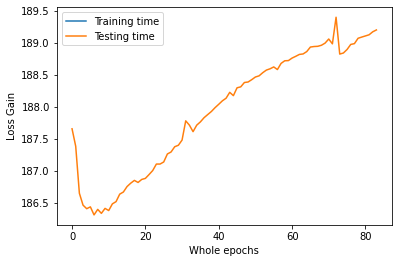

In [54]:
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel('Whole epochs')
plt.ylabel('Loss Gain')
plt.plot(train_loss, label='Training time')
plt.plot(test_loss, label='Testing time')
plt.legend()
plt.show()

### Intent x Epoch

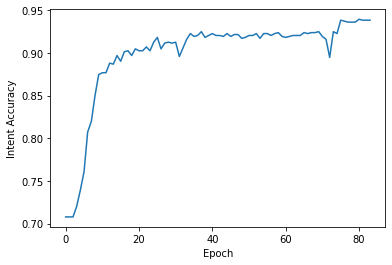

In [55]:
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Intent Accuracy')
plt.plot(intent_acc)
plt.show()

### Slots F1 x Epoch

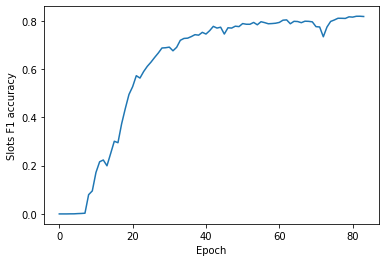

In [56]:
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Slots F1 accuracy')
plt.plot(slots_f1)
plt.show()